### OpenCV DNN 패키지 -> Pretrained Faster R-CNN 모델 다운로드 후 Object Detection 수행 (이미지)

#### 원본 이미지 다운로드/확인

--2025-02-27 03:21:46--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2025-02-27 03:21:46 (12.9 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



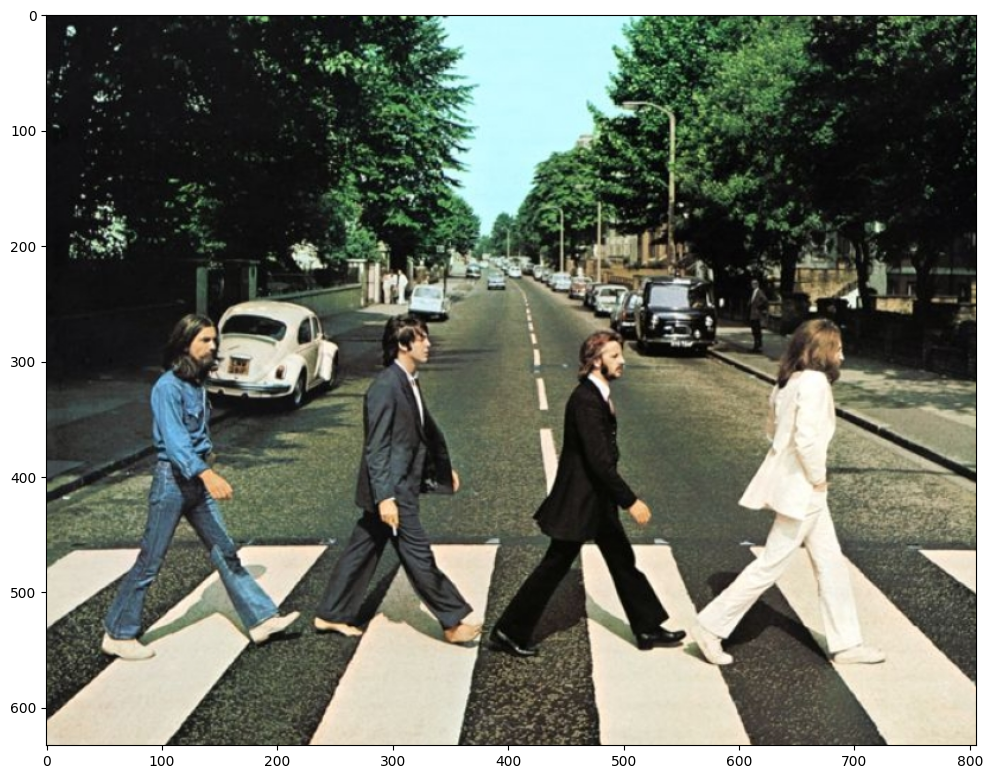

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 이미지 저장할 폴더 생성
# !mkdir "폴더 생성 경로"
!mkdir /content/data

# detection에 사용할 원본 이미지 다운로드
# !wget -0 "저장 경로" "다운로드 경로"
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

# 이미지 불러오기
# cv2.imread("이미지 경로")
img = cv2.imread('./data/beatles01.jpg')

# 이미지 색상 형식 변경
# BGR -> RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 이미지 시각화
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### Pretrained 모델과 환경파일 다운로드

In [ ]:
# pretrained 모델/설정 파일 저장할 폴더 생성
!mkdir ./pretrained

# pretrained Faster R-CNN 모델(가중치) 다운로드 후 pretrained 폴더에 저장(압축본)
!wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz

# openCV 설정 파일 다운로드해 pretrained 폴더에 저장
!wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

# 모델 파일 압축 해제
!tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained

# 다운받은 파일 확인
# !pwd -> 현재 작업중인 디렉터리 경로 출력
!pwd

# 파일 내용 확인
# !ls -lia "파일 경로"
!ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28

--2025-02-27 03:21:53--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.117.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M   136MB/s    in 2.7s    

2025-02-27 03:21:56 (136 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2025-02-27 03:21:56--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercont

#### cv2.dnn.readNetFromTensorflow()를 이용해 모델 불러오기

In [ ]:
# readNetFromTensorflow("모델 가중치", "openCV 설정파일")
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_graph.pbtxt')

#### coco 데이터 세트의 "클래스id - 클래스명" 매핑 딕셔너리

In [ ]:
# OpenCV Tensorflow Faster-RCNN용
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

#### 단일 이미지 object detection 수행 함수 제작

In [ ]:
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):

    # Faster R-CNN 모델은 이미지를 resize해 처리함.
    # 즉, resize된 이미지에 맞춰 detection이 수행되어 바운딩 박스가 그려짐.
    # 따라서 이후 원본 이미지 크기에 맞게 바운딩 박스를 그리기 위해서는 변형이 필요.
    # 이를 위해 원본 이미지 정보 저장.
    rows = img_array.shape[0]
    cols = img_array.shape[1]

    # cv2.rectangle()는 인자로 받은 이미지에 바운딩 박스를 바로 그리기에, 바운딩 박스를 그릴 이미지 복사본 생성.
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array

    # 이미지 전처리 및 모델에 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False))

    # object detection 수행 후 cv_out에 저장.
    # 수행 결과: (a, b, c, 7)
    # a = 입력 이미지 개수, b = 네트워크 헤더 정보, c = 감지된 객체 수, 7 = 각 객체의 세부정보 7개
    # 7개의 세부정보: 배치ID, 클래스ID, 신뢰도, 바운딩 박스 좌표(좌상단 x, y, 우하단 x, y)
    cv_out = cv_net.forward()

    # 객체 탐지 수행 시간 측정 준비
    start = time.time()

    # 바운딩 박스/정보글 시각화 준비
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # 반복문을 통해 cv_out안의 정보를 탐색하며, 각 object마다 바운딩 박스와 정보글 표시.
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2]) # 신뢰도
        class_id = int(detection[1]) # 클래스ID

        # detected된 object들의 score가 함수 인자로 들어온 score_threshold 이상만 추출
        if score > score_threshold:
            # 바운딩 박스 좌표를 원본 이미지 크기에 맞게 다시 계산.
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows

            # 각 객체마다 클래스ID에 해당하는 클래스명과 신뢰도 출력
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            print(caption)

            # cv2.rectangle()를 통해 바운딩 박스 그리기.
            # cv2.putText()를 통해 클래스명과 신뢰도 표시.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

    # 수행시간 출력
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

#### 함수를 이용해 detection 수행

person: 0.9998
person: 0.9996
person: 0.9993
person: 0.9970
person: 0.8995
car: 0.8922
car: 0.7602
car: 0.7415
car: 0.6929
car: 0.6918
car: 0.6896
car: 0.6717
car: 0.6521
car: 0.5730
car: 0.5679
car: 0.5261
car: 0.5012
Detection 수행시간: 0.0 초


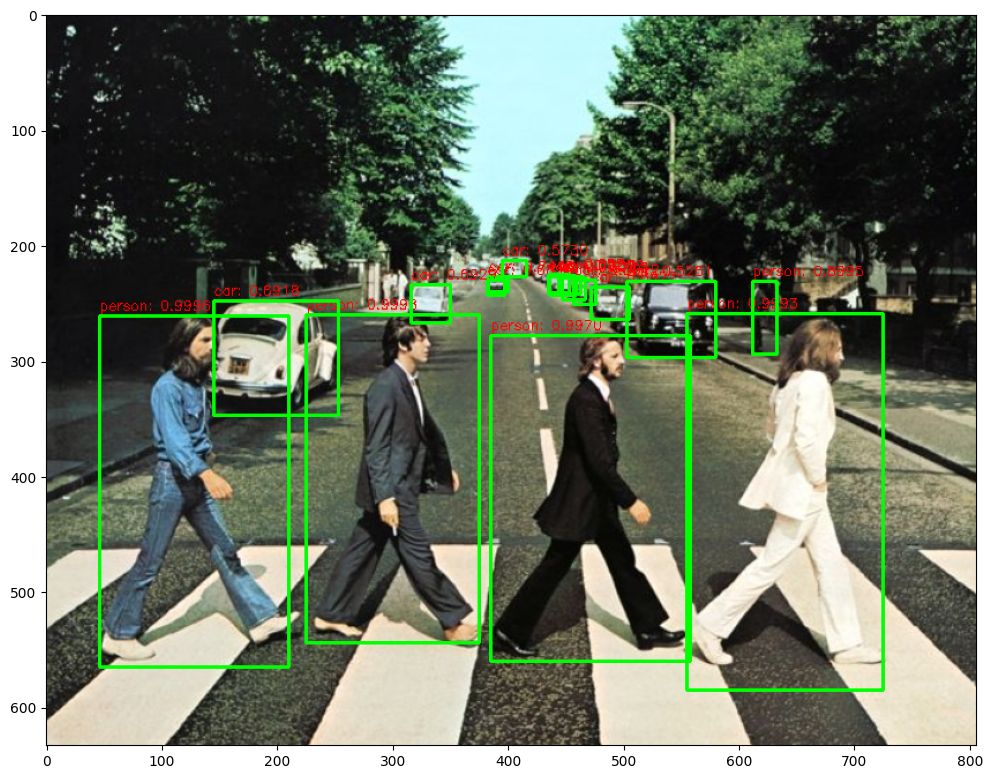

In [ ]:
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

# 수행결과 이미지 색상 형식 변형
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

# 최종 시각화
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### OpenCV DNN 패키지 -> Pretrained Faster R-CNN 모델 다운로드 후 Object Detection 수행 (영상)

#### 원본 영상 다운로드/확인

In [ ]:
# 원본 영상 다운로드
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2025-02-27 03:29:04--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/refs/heads/master/data/video/John_Wick_small.mp4 [following]
--2025-02-27 03:29:04--  https://github.com/chulminkw/DLCV/raw/refs/heads/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/refs/heads/master/data/video/John_Wick_small.mp4 [following]
--2025-02-27 03:29:05--  https://raw.githubusercontent.com/chulminkw/DLCV/refs/heads/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.

#### 영상 object detection 수행 함수 제작

In [ ]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):

    # 원본 영상 읽어오기
    # cv2.VideoCapture("경로")
    cap = cv2.VideoCapture(input_path)

    # 영상 인코딩 타입 설정
    codec = cv2.VideoWriter_fourcc(*'XVID')

    # 원본 영상의 총 프레임 갯수 계산 및 출력
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    # detection 완료 영상 저장 시 해상도와 fps를 유지하기 위해 원본 영상의 정보 저장
    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) # 해상도
    vid_fps = cap.get(cv2.CAP_PROP_FPS) # fps

    # detection 완료 영상 저장할 객체 생성
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    # 바운딩 박스/정보글 시각화 준비
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    score_threshold = 0.5

    while True:
        # 더 읽을 frame이 없을 시 반복문 탈출.
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        # 한 프레임을 이전에 작성한 단일 이미지 detection 함수에 입력해 detection 수행.
        img_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=False, is_print=is_print)

        # detection 완료한 프레임을 하나씩 vid_writer 객체에 저장.
        vid_writer.write(img_frame)

    # 영상 object detection 완료
    vid_writer.release()
    cap.release()

#### 함수를 이용해 detection 수행

In [ ]:
do_detected_video(cv_net, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.2, False)

총 Frame 갯수: 58
car: 0.9882
car: 0.9622
person: 0.9495
car: 0.9266
car: 0.8772
motorcycle: 0.6607
car: 0.9881
car: 0.9643
person: 0.9581
car: 0.9318
car: 0.8992
motorcycle: 0.5682
car: 0.9903
car: 0.9833
motorcycle: 0.9532
car: 0.9115
car: 0.8625
person: 0.7814
person: 0.5169
car: 0.9919
car: 0.9909
car: 0.9870
motorcycle: 0.8655
person: 0.7585
person: 0.7484
person: 0.7375
car: 0.7361
person: 0.7200
car: 0.6120
car: 0.9933
car: 0.9817
motorcycle: 0.9781
car: 0.9530
car: 0.7823
person: 0.5313
car: 0.9799
car: 0.9678
car: 0.9496
person: 0.8299
car: 0.6521
motorcycle: 0.6003
car: 0.9809
car: 0.9647
car: 0.9632
person: 0.8467
car: 0.7496
car: 0.6391
motorcycle: 0.5894
person: 0.5808
car: 0.9844
motorcycle: 0.9825
car: 0.9683
car: 0.9670
car: 0.5693
car: 0.9877
car: 0.9737
car: 0.9403
car: 0.9125
motorcycle: 0.8699
person: 0.6535
car: 0.9902
car: 0.9878
car: 0.9599
motorcycle: 0.9435
car: 0.7138
person: 0.5800
cup: 0.5553
car: 0.9907
car: 0.9776
motorcycle: 0.9524
car: 0.8853
person: 0.8192